In [ ]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import vit_b_16
from sklearn.metrics import accuracy_score


In [ ]:

!kaggle datasets download pragatisethi2/diabetic-retinopathy-v1

Dataset URL: https://www.kaggle.com/datasets/pragatisethi2/diabetic-retinopathy-v1
License(s): unknown
 98% 343M/350M [00:04<00:00, 80.2MB/s]
100% 350M/350M [00:04<00:00, 80.1MB/s]


In [ ]:
!unzip /content/diabetic-retinopathy-v1.zip -d /content/

Archive:  /content/diabetic-retinopathy-v1.zip
  inflating: /content/Retina/Retina/Healthy/Healthy.png  
  inflating: /content/Retina/Retina/Healthy/Healthy_10.png  
  inflating: /content/Retina/Retina/Healthy/Healthy_100.png  
  inflating: /content/Retina/Retina/Healthy/Healthy_1000.png  
  inflating: /content/Retina/Retina/Healthy/Healthy_101.png  
  inflating: /content/Retina/Retina/Healthy/Healthy_102.png  
  inflating: /content/Retina/Retina/Healthy/Healthy_103.png  
  inflating: /content/Retina/Retina/Healthy/Healthy_104.png  
  inflating: /content/Retina/Retina/Healthy/Healthy_105.png  
  inflating: /content/Retina/Retina/Healthy/Healthy_106.png  
  inflating: /content/Retina/Retina/Healthy/Healthy_107.png  
  inflating: /content/Retina/Retina/Healthy/Healthy_108.png  
  inflating: /content/Retina/Retina/Healthy/Healthy_109.png  
  inflating: /content/Retina/Retina/Healthy/Healthy_11.png  
  inflating: /content/Retina/Retina/Healthy/Healthy_110.png  
  inflating: /content/Retina

In [ ]:
# Set the base path to your dataset
BASE_PATH = "/content/"


In [ ]:
# Load the CSV files
train = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
valid = pd.read_csv(os.path.join(BASE_PATH, 'valid.csv'))
test = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))

# Modify path construction
train['Paths'] = BASE_PATH + 'Retina/' + train['Paths']
valid['Paths'] = BASE_PATH + 'Retina/' + valid['Paths']
test['Paths'] = BASE_PATH + 'Retina/' + test['Paths']

# Map labels to numerical values and ensure they are integers
label_mapping = {
    'No DR': 0,
    'Mild DR': 1,
    'Moderate DR': 2,
    'Severe DR': 3,
    'Proliferative DR': 4
}

In [ ]:
train.head()

,Paths,Labels
0,/content/Retina/Retina/Moderate DR/Moderate_DR...,Moderate DR
1,/content/Retina/Retina/Moderate DR/Moderate_DR...,Moderate DR
2,/content/Retina/Retina/Mild DR/Mild_DR_303.png,Mild DR
3,/content/Retina/Retina/Moderate DR/Moderate_DR...,Moderate DR
4,/content/Retina/Retina/Severe DR/Severe DR_103...,Severe DR


In [ ]:
train['Labels'] = train['Labels'].map(label_mapping).fillna(-1).astype(int)
valid['Labels'] = valid['Labels'].map(label_mapping).fillna(-1).astype(int)
test['Labels'] = test['Labels'].map(label_mapping).fillna(-1).astype(int)


In [ ]:
train = train[train['Labels'] != -1]
valid = valid[valid['Labels'] != -1]
test = test[test['Labels'] != -1]


In [ ]:
print("Train labels:")
print(train['Labels'].unique())
print("Validation labels:")
print(valid['Labels'].unique())
print("Test labels:")
print(test['Labels'].unique())


Train labels:
[2 1 3]
Validation labels:
[2 3 1]
Test labels:
[2 1 3]


In [ ]:
train.head()

,Paths,Labels
0,/content/Retina/Retina/Moderate DR/Moderate_DR...,2
1,/content/Retina/Retina/Moderate DR/Moderate_DR...,2
2,/content/Retina/Retina/Mild DR/Mild_DR_303.png,1
3,/content/Retina/Retina/Moderate DR/Moderate_DR...,2
4,/content/Retina/Retina/Severe DR/Severe DR_103...,3


In [ ]:
# Define data transformations
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # Use ImageNet normalization for pre-trained models
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225))
])

In [ ]:
# Custom Dataset class for MIL-ViT
class MIL_ViTDataset(Dataset):
    def __init__(self, df, transform=None, patch_size=224, num_patches=16):
        self.paths = df['Paths'].values
        self.labels = df['Labels'].values
        self.transform = transform
        self.patch_size = patch_size
        self.num_patches = num_patches

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        label = self.labels[idx]

        image = Image.open(img_path).convert('RGB')
        width, height = image.size

        # Create patches
        patches = []
        for _ in range(self.num_patches):
            left = np.random.randint(0, width - self.patch_size)
            top = np.random.randint(0, height - self.patch_size)
            right = left + self.patch_size
            bottom = top + self.patch_size
            patch = image.crop((left, top, right, bottom))
            if self.transform:
                patch = self.transform(patch)
            patches.append(patch)

        patches = torch.stack(patches)

        return patches, label

In [ ]:
# Define the MIL-ViT model
class MIL_ViT_Model(nn.Module):
    def __init__(self, num_classes):
        super(MIL_ViT_Model, self).__init__()
        # Load pre-trained ViT model
        self.vit = vit_b_16(pretrained=True)
        # Remove the classification head
        self.vit.heads = nn.Identity()
        # Define classifier
        self.classifier = nn.Linear(self.vit.hidden_dim, num_classes)

    def forward(self, x):
        # x shape: [batch_size, num_patches, channels, H, W]
        batch_size, num_patches, channels, H, W = x.size()
        x = x.view(batch_size * num_patches, channels, H, W)
        features = self.vit(x)
        # Reshape to [batch_size, num_patches, hidden_dim]
        features = features.view(batch_size, num_patches, -1)
        # Aggregate features
        aggregated_features = torch.mean(features, dim=1)
        output = self.classifier(aggregated_features)
        return output

In [ ]:
# Prepare DataLoaders
batch_size = 4

train_dataset = MIL_ViTDataset(train, transform=data_transforms)
valid_dataset = MIL_ViTDataset(valid, transform=data_transforms)
test_dataset = MIL_ViTDataset(test, transform=data_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


In [ ]:

# Instantiate the model, loss function, and optimizer
num_classes = len(label_mapping)
model = MIL_ViT_Model(num_classes=num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    total_preds = []
    total_labels = []
    for patches, labels in tqdm(loader):
        patches = patches.to(device)
        labels = labels.long().to(device)  # Explicitly convert to LongTensor

        optimizer.zero_grad()
        outputs = model(patches)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * patches.size(0)
        _, preds = torch.max(outputs, 1)
        total_preds.extend(preds.cpu().numpy())
        total_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = accuracy_score(total_labels, total_preds)
    return epoch_loss, epoch_acc

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    total_preds = []
    total_labels = []
    with torch.no_grad():
        for patches, labels in tqdm(loader):
            patches = patches.to(device)
            labels = labels.long().to(device)  # Explicitly convert to LongTensor

            outputs = model(patches)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * patches.size(0)
            _, preds = torch.max(outputs, 1)
            total_preds.extend(preds.cpu().numpy())
            total_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = accuracy_score(total_labels, total_preds)
    return epoch_loss, epoch_acc


In [ ]:
# Training loop
num_epochs = 20
best_acc = 0.0

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    valid_loss, valid_acc = validate(model, valid_loader, criterion, device)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Valid Loss: {valid_loss:.4f} | Valid Acc: {valid_acc:.4f}")

    # Save the model if validation accuracy improves
    if valid_acc > best_acc:
        best_acc = valid_acc
        torch.save(model.state_dict(), 'best_model.pth')

# Load the best model and evaluate on the test set
model.load_state_dict(torch.load('best_model.pth'))
test_loss, test_acc = validate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

Epoch 1/20
Epoch 1: 100%|██████████| 220/220 [04:02<00:00,  1.10s/batch, accuracy=0.714, loss=0.502] 
Epoch [1/20], Loss: 0.7659, Accuracy: 0.7142
Validation: 100%|██████████| 55/55 [00:22<00:00,  2.46batch/s, accuracy=0.795, loss=0.516]
Validation Loss: 0.5631, Validation Accuracy: 0.7955
Epoch 2/20
Epoch 2: 100%|██████████| 220/220 [03:34<00:00,  1.02batch/s, accuracy=0.78, loss=0.77]   
Epoch [2/20], Loss: 0.5916, Accuracy: 0.7795
Validation: 100%|██████████| 55/55 [00:19<00:00,  2.79batch/s, accuracy=0.802, loss=0.466]
Validation Loss: 0.5195, Validation Accuracy: 0.8023
Epoch 3/20
Epoch 3: 100%|██████████| 220/220 [03:39<00:00,  1.00batch/s, accuracy=0.794, loss=0.487] 
Epoch [3/20], Loss: 0.5469, Accuracy: 0.7937
Validation: 100%|██████████| 55/55 [00:20<00:00,  2.73batch/s, accuracy=0.748, loss=0.687]
Validation Loss: 0.5898, Validation Accuracy: 0.7477
Epoch 4/20
Epoch 4: 100%|██████████| 220/220 [04:00<00:00,  1.09s/batch, accuracy=0.787, loss=0.442] 
Epoch [4/20], Loss: 0.555

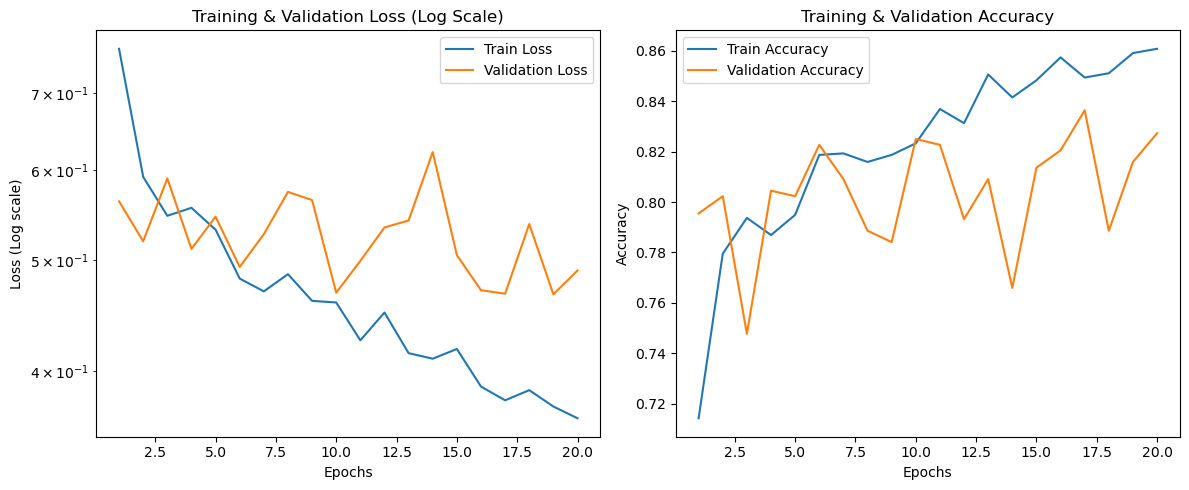

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Lists from your training loop:
train_loss_list = [
    0.7659, 0.5916, 0.5469, 0.5558, 0.5318, 0.4819, 0.4696, 0.4862, 0.4607, 0.4592,
    0.4255, 0.4500, 0.4146, 0.4100, 0.4181, 0.3876, 0.3770, 0.3848, 0.3723, 0.3636
]
val_loss_list = [
    0.5631, 0.5195, 0.5898, 0.5116, 0.5460, 0.4933, 0.5270, 0.5739, 0.5645, 0.4684,
    0.4994, 0.5342, 0.5418, 0.6219, 0.5052, 0.4707, 0.4674, 0.5379, 0.4668, 0.4898
]
train_acc_list = [
    0.7142, 0.7795, 0.7937, 0.7869, 0.7949, 0.8187, 0.8193, 0.8159, 0.8187, 0.8233,
    0.8369, 0.8313, 0.8506, 0.8415, 0.8483, 0.8574, 0.8494, 0.8511, 0.8591, 0.8608
]
val_acc_list = [
    0.7955, 0.8023, 0.7477, 0.8045, 0.8023, 0.8227, 0.8091, 0.7886, 0.7841, 0.8250,
    0.8227, 0.7932, 0.8091, 0.7659, 0.8136, 0.8205, 0.8364, 0.7886, 0.8159, 0.8273
]

epochs = range(1, 21)

# Plot log-scaled Training & Validation Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_list, label='Train Loss')
plt.plot(epochs, val_loss_list, label='Validation Loss')
plt.yscale('log')  # Log scale for loss
plt.xlabel('Epochs')
plt.ylabel('Loss (Log scale)')
plt.title('Training & Validation Loss (Log Scale)')
plt.legend()

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_list, label='Train Accuracy')
plt.plot(epochs, val_acc_list, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
def get_predictions(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    true_labels = []

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)  # Forward pass
            
            # Extract the logits (assuming your model outputs ImageClassifierOutput)
            logits = outputs.logits  # This gets the raw output (logits)

            # Get the predicted class
            _, preds = torch.max(logits, 1)

            predictions.extend(preds.cpu().numpy())  # Move to CPU before converting to numpy
            true_labels.extend(labels.cpu().numpy())  # Move to CPU before converting to numpy

    return np.array(predictions), np.array(true_labels)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_pred and y_true have been computed using the get_predictions function
y_pred, y_true = get_predictions(model,  valid_loader)


print(classification_report(y_true, y_pred))




              precision    recall  f1-score   support

           0       0.94      1.00      0.97       103
           1       1.00      0.89      0.94        38
           2       0.69      0.97      0.81        77
           3       0.82      0.38      0.52        37
           4       0.80      0.20      0.32        20

    accuracy                           0.84       275
   macro avg       0.85      0.69      0.71       275
weighted avg       0.85      0.84      0.81       275

